In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import numpy as np
import keras
import scipy
import matplotlib.pyplot as plt
from time import time


In [2]:
def DataPreprocessing(data, ff):

    fmat = {0.1:data['sbsl_PINN'][0][0], 0.08:data['sbsl_PINN'][1][0], 0.06:data['sbsl_PINN'][2][0], 0.04:data['sbsl_PINN'][3][0], 0.02:data['sbsl_PINN'][4][0], 0.01:data['sbsl_PINN'][5][0], 0.005:data['sbsl_PINN'][6][0], 0.0:data['sbsl_PINN'][7][0]}
    fval = [0.1  , 0.08 , 0.06 , 0.04 , 0.02 , 0.01 , 0.005, 0.000]
    i = ff
    N = fmat[i].shape[1]
    U = np.zeros((N,4))
    U[:,0] = data['eta']
    U[:,1] = fmat[i][0,:]
    U[:,2] = fmat[i][1,:]
    U[:,3] = fmat[i][2,:]
    #U[:,4] = torch.from_numpy(np.array([0.06]))

    D = np.array(data['D'])
    M = np.array(data['M'])
    u = np.array(data['ubar'])
    dMdx = np.array(data['dMdx'])
    dudx = np.array(data['dudx'])
    alpha = np.array(data['alp'])
    eta1 = np.array(data['eta'])   

    meanflow = np.zeros((D.shape[1],7))
    meanflow[:,0] = D
    meanflow[:,1] = M
    meanflow[:,2] = u
    meanflow[:,3] = dMdx
    meanflow[:,4] = dudx
    meanflow[:,5] = alpha
    meanflow[:,6] = eta1
    #meanflow = torch.tile(meanflow, (8,1))

    he = np.array([0.00])
    HE = np.tile(he, (N,1)) 
    #He = HE.flatten()[:,None]

    uu = U[:, 1:4]
    uu0 = U[:,0]
    uu0 = uu0.flatten()[:, None]

    input_set = np.concatenate([HE, uu0],1)

    return input_set, uu, meanflow

In [3]:
data = scipy.io.loadmat('/Users/ramtarun/Desktop/Cambridge/Indirect-Noise-in-Nozzles/Data/Data_PINN_subsonic_geom_linvelsup_f0-0.1.mat')
inputs, targets, meanflow = DataPreprocessing(data, ff=0.01)

In [4]:
inputs.shape

(1001, 2)

In [5]:

def split_data(U, b_size, n_batches):
    '''
    Splits the data in batches. Each batch is created by sampling the signal with interval
    equal to n_batches.
    '''
    data   = np.zeros((n_batches, b_size, U.shape[1]), dtype=float)    
    for j in range(n_batches):
        data[j,:b_size] = U[::skip][j::n_batches].copy()

    return data

In [6]:
skip = 5
b_size = 10
n_batches = 20
val_batches = n_batches//25   #validation batches

In [7]:
x_tt = inputs[:b_size*n_batches*skip].copy()
y_tt = targets[:b_size*n_batches*skip].copy()
m_tt = meanflow[:b_size*n_batches*skip].copy()

Y_train     = split_data(y_tt, b_size, n_batches).astype(dtype=np.float32)
X_train     = split_data(x_tt, b_size, n_batches).astype(dtype=np.float32)
Meanflow_train = split_data(m_tt, b_size, n_batches).astype(dtype=np.float32)

In [8]:
x_vv        = inputs[b_size*n_batches*skip:b_size*n_batches*skip+b_size*val_batches*skip:].copy()
Y_vv        = targets[b_size*n_batches*skip:b_size*n_batches*skip+b_size*val_batches*skip:].copy()
meanflow_vv = meanflow[b_size*n_batches*skip:b_size*n_batches*skip+b_size*val_batches*skip:].copy()
Y_val       = split_data(Y_vv, b_size, val_batches).astype(dtype=np.float32) 
X_val       = split_data(x_vv, b_size, val_batches).astype(dtype=np.float32)
Meanflow_val = split_data(meanflow_vv, b_size, val_batches).astype(dtype=np.float32)

#how much of the data we are using for training
print(f"Train Data % : {((b_size*n_batches*skip/inputs.shape[0])*100):.4f}")
print(f"Validation Data % : {((b_size*val_batches*skip/inputs.shape[0])*100):.4f}")


Train Data % : 99.9001
Validation Data % : 0.0000


In [9]:
X_train = tf.Variable(X_train)
Y_train = tf.Variable(Y_train)
Meanflow_train = tf.Variable(Meanflow_train)
# X_train

2023-08-12 19:23:04.586436: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-12 19:23:04.586458: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-12 19:23:04.586465: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-12 19:23:04.586660: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-12 19:23:04.586678: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
def RHS_ff_t(y, baseflow, f):

    pi_p, pi_m, sig = tf.unstack(y,axis=1)

    D = baseflow[:,0]
    M = baseflow[:,1]
    u = baseflow[:,2]
    dMdx = baseflow[:,3]
    dudx = baseflow[:,4]
    alpha = baseflow[:,5]
    eta1 = baseflow[:,6]    
    
    He = 0#a constant input

    gamma = 1.4#constant
    
    Msq = tf.math.square(M)

    Lambda = 1 + Msq * (gamma-1)/2
    zeta = f*gamma*Msq - 2*tf.math.tan(alpha)
    C1= ((gamma - 1)*(1-Msq)*f)/(2*Lambda*zeta)
    Ca = -C1*M*u*dMdx*(2-(2*Msq/(1-Msq)) - (2*gamma*Msq*(-2*f*Lambda - (gamma-1)/gamma *zeta)/(2*Lambda*zeta)))
    Ff = -(dudx + (4*f*u/(2*D)))

    denom = (M**2*u - u + C1*Msq *u + C1*Msq*Msq*gamma*u) #M**4
    vrh_p = M*(2*(1-M) + C1*M*(M-2+M*gamma*(1-2*M)))/(2*denom)
    vrh_m = -M*(2*(1+M) + C1*M*(M+2+M*gamma*(1+2*M)))/(2*denom)
    vkp_p = Msq*C1*(2+M*(gamma-1))/(2*denom)
    vkp_m = Msq*C1*(2-M*(gamma-1))/(2*denom)
    vth_p = C1*M*(M*(1+gamma) + M**2*(1-gamma) - 2)/denom
    vth_m = C1*M*(M*(1+gamma) - M**2*(1-gamma) + 2)/denom
    vsig = -(C1*Msq*(1+gamma*Msq) + Msq - 1)/denom
    calM = dMdx/(2*M)
    kp_p = (gamma - 1) + (2/M)
    kp_m = (gamma - 1) - (2/M)
    Gm_p = M*(Ca*(M + 1) + Ff*M*(C1*gamma*M*Msq + M + (1 - C1*Msq)))/(2*denom)
    Gm_m = M*(Ca*(M - 1) - Ff*M*(C1*gamma*M*Msq + M - (1 - C1*Msq)))/(2*denom)
    Ups = (Ca*(Msq - 1) - C1*Ff*Msq*Msq *(1+gamma))/denom
    
#     eq1 = - (2*np.pi*1j*He*vrh_p + Gm_m*kp_m + calM)*pi_p + (2*np.pi*1j*He*vkp_p + Gm_m*kp_p + calM)*pi_m - Gm_m*sig
#     eq2 = - (2*np.pi*1j*He*vkp_m + Gm_p*kp_m - calM)*pi_p - (2*np.pi*1j*He*vrh_m + Gm_p*kp_p + calM)*pi_m - Gm_m*sig
#     eq3 = - (2*np.pi*1j*He*vth_p + Ups*kp_m)*pi_p - (2*np.pi*1j*He*vth_m + Ups*kp_p)*pi_m - (2*np.pi*1j*He*vsig + Ups)*sig
    
#     eq1 = - tf.multiply((Gm_m*kp_m + calM),pi_p) + tf.multiply(( Gm_m*kp_p + calM),pi_m) - tf.multiply(Gm_m,sig)
    eq1 =  (Gm_m*kp_m + calM)*pi_p + ( Gm_m*kp_p - calM)*pi_m + Gm_m*sig
    eq2 =  ( Gm_p*kp_m - calM)*pi_p + ( Gm_p*kp_p + calM)*pi_m + Gm_m*sig
    eq3 =  ( Ups*kp_m)*pi_p + ( Ups*kp_p)*pi_m + (Ups)*sig
    

    rhs = tf.stack([-eq1, -eq2, -eq3],axis=1)

    return rhs

In [11]:
def pde_residual(r_n, gr):
    return r_n + gr

In [12]:
def init_model(num_hidden_layers, num_neurons_per_layer):

    ### Keras Sequential API 
    # # Initialize a feedforward neural network
    # model = tf.keras.Sequential()

    # # Input is two-dimensional (He + one spatial dimension)
    # model.add(tf.keras.Input(2))

    # # Append hidden layers
    # for _ in range(num_hidden_layers):
    #     model.add(tf.keras.layers.Dense(num_neurons_per_layer,
    #         activation=tf.keras.activations.get('tanh'),
    #         kernel_initializer='glorot_normal'))

    # # Output is one-dimensional
    # model.add(tf.keras.layers.Dense(3, name='Travelling_Waves'))
    # model.add(tf.keras.layers.Dense(1, name='Friction_Factor'))

    ### Keras Functional API
    inputs = keras.Input(shape= (None,2))
    x = inputs
    for _ in range(num_hidden_layers):
        x = keras.layers.Dense(num_neurons_per_layer, activation='tanh')(x)

    outputs1 = keras.layers.Dense(3, activation='sigmoid', name='State_Vector')(x)
    outputs2 = keras.layers.Dense(1, activation='sigmoid', name='Friction_Factor')(x)  # Assuming two outputs for regression tasks



    model = keras.Model(inputs=inputs, outputs=[outputs1, outputs2])
    
    return model



In [13]:
def get_r(model, X_r, baseflow):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        # he, n = X_r[:, 0], X_r[:,1]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(X_r)
        # tape.watch(n)

        # Determine residual 
        r, f = model(X_r)
        f_mean = tf.reduce_mean(f)
        # Compute gradient r_n within the GradientTape
        # if we need second derivatives
    r_n = tape.gradient(r,X_r)
    r_n = tf.reshape(r_n[:,1], [b_size,1])
    del tape
    # pde_residual(r_n, RHS_ff_t(r, baseflow, f_mean))
    return pde_residual(r_n, RHS_ff_t(r, baseflow, f_mean))

In [14]:
def compute_loss(model, X_r, Y_r, baseflow):
    
    # Compute phi^r
    r = get_r(model, X_r, baseflow)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = 0.0001*phi_r
    
    # # Add phi^0 and phi^b to the loss
    # for i in range(len(X_data)):
    #     u_pred = model(X_data[i])
    #     loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))

    pred, f = model(X_r)
    loss += tf.reduce_mean(tf.square(pred - Y_r))
    
    return loss

In [15]:
def get_grad(model, X_r, Y_r, baseflow):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, Y_r, baseflow)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [16]:
num_hidden_layers = 4
num_neurons_per_layer = 8
# Initialize model aka u_\theta
model = init_model(num_hidden_layers, num_neurons_per_layer)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True)


# Choose the optimizer
optim = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 2)]            0         []                            
                                                                                                  
 dense (Dense)               (None, None, 8)              24        ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, None, 8)              72        ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, None, 8)              72        ['dense_1[0][0]']             
                                                                                              

In [64]:
class CustomProgbarLogger(tf.keras.callbacks.Callback):
    def __init__(self, print_frequency, progbar_length, count_mode='steps'):
        super(CustomProgbarLogger, self).__init__()
        self.count_mode = count_mode
        self.print_frequency = print_frequency
        self.progbar_length = progbar_length

    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.steps_per_epoch = self.params['steps']
        self.total_batches = self.epochs * self.steps_per_epoch
        self.target = self.total_batches if self.count_mode == 'steps' else self.epochs
        

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch
        self.batch_index = 0
        self.progbar = tf.keras.utils.Progbar(target=self.steps_per_epoch, verbose=1)
        

    def on_batch_end(self, batch, logs=None):
        self.batch_index += 1
        # if self.count_mode == 'steps':
        #     self.progbar.update(self.batch_index, [('loss', logs['loss'])], finalize=False)
        # else:
        #     self.progbar.update(self.epoch * self.steps_per_epoch + self.batch_index, [('loss', logs['loss'])], finalize=False)

    def on_epoch_end(self, epoch, logs=None):
        # self.progbar.update(self.epoch * self.steps_per_epoch + self.steps_per_epoch, [('loss', logs['loss'])], finalize=True)
        # if (self.epoch + 1) % self.print_frequency == 0 or self.epoch == self.epochs - 1:
        #     print()
         if (self.epoch + 1) % self.print_frequency == 0 or self.epoch == self.epochs - 1:
            # Calculate the progress percentage
            progress = (self.epoch + 1) / self.epochs * 100

            # Truncate the progress percentage to two decimal places
            progress_str = "{:.2f}".format(progress)

            # Set the progress bar length
            filled_length = int(self.progbar_length * (self.epoch + 1) / self.epochs)
            bar = '=' * filled_length + '-' * (self.progbar_length - filled_length)

            print(f"Epoch {self.epoch + 1}/{self.epochs} [{bar}] - {progress_str}% - loss: {logs['loss']:.4f}")

        

    def on_train_end(self, logs=None):
        pass

    def set_params(self, params):
        self.params = params
        self.progbar = tf.keras.utils.Progbar(target=self.target, verbose=1)

In [65]:
# Create an instance of the CustomProgbarLogger
progbar_logger = CustomProgbarLogger(count_mode='steps', print_frequency=100, progbar_length=30)


In [66]:
# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step(X_r, Y_r, baseflow):

    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, Y_r, baseflow)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss


In [67]:
# Number of training epochs
N = 7500
hist = np.zeros(N+1)
progbar_logger.params = {'epochs': N, 'steps': n_batches}
progbar = tf.keras.utils.Progbar(N, stateful_metrics=["loss"])



In [68]:
# Start timer
t0 = time()
progbar_logger.on_train_begin()
for i in range(N+1):
    progbar_logger.on_epoch_begin(i)
    loss = 0
    for j in range(n_batches):
        loss = train_step(X_train[j], Y_train[j], Meanflow_train[j])
        # Append current loss to hist
        loss += loss.numpy()
        # Update the custom callback with the current training loss
        progbar_logger.on_batch_end(j, logs={'loss': loss})

    # At the end of each epoch, call on_epoch_end to finalize the progress bar for the epoch
    
    
    loss = loss/n_batches
    hist[i] = loss
    progbar_logger.on_epoch_end(i, logs={'loss': loss})
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

2023-07-25 21:35:10.589222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 100/7500 [------------------------------] - 1.33% - loss: 0.0219
Epoch 200/7500 [------------------------------] - 2.67% - loss: 0.0215
Epoch 300/7500 [=-----------------------------] - 4.00% - loss: 0.0204
Epoch 400/7500 [=-----------------------------] - 5.33% - loss: 0.0180
Epoch 500/7500 [==----------------------------] - 6.67% - loss: 0.0136
Epoch 600/7500 [==----------------------------] - 8.00% - loss: 0.0087
Epoch 700/7500 [==----------------------------] - 9.33% - loss: 0.0051
Epoch 800/7500 [===---------------------------] - 10.67% - loss: 0.0031
Epoch 900/7500 [===---------------------------] - 12.00% - loss: 0.0023
Epoch 1000/7500 [====--------------------------] - 13.33% - loss: 0.0019
Epoch 1100/7500 [====--------------------------] - 14.67% - loss: 0.0017
Epoch 1200/7500 [====--------------------------] - 16.00% - loss: 0.0016
Epoch 1300/7500 [=====-------------------------] - 17.33% - loss: 0.0016
Epoch 1400/7500 [=====-------------------------] - 18.67% - loss: 0

1/1 [==============================] - 0s 187ms/step


2023-07-26 00:22:46.237081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.45214596


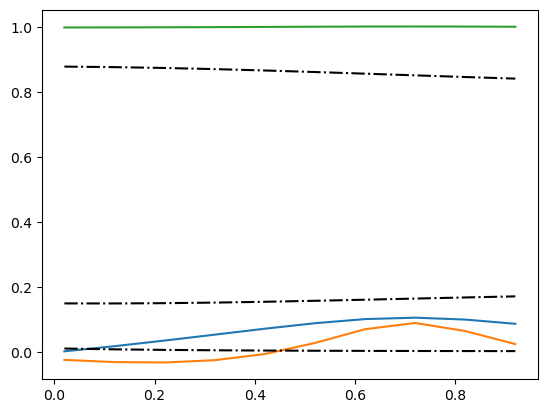

In [69]:
r, f = model.predict(X_train[4])
print(np.mean(f))

plt.plot(X_train[4][:,1], Y_train[4])
plt.plot(X_train[4][:,1], r, 'k-.')

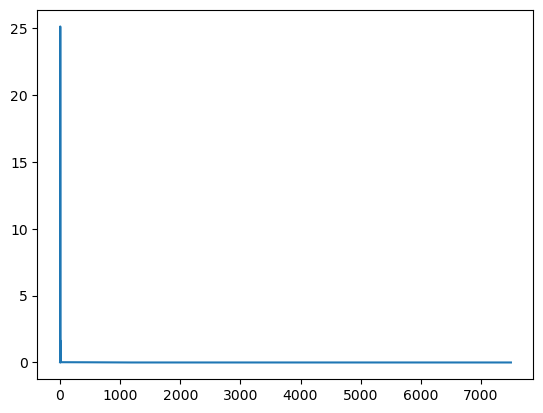

In [70]:
plt.plot(hist)